In [1]:

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import IPython
from glob import glob
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
import tqdm
#import seaborn as sns
import albumentations as A
import torch
import torch.nn as nn
import timm
import torcheval 
import wandb
import torchvision
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import seaborn as sns
from albumentations.pytorch import ToTensorV2
plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})
import psutil
import imageio.v3 as imageio

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:
RANDOM_NUMBER = 42
torch.manual_seed(RANDOM_NUMBER)

# select Device

In [3]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
DATA_DIRECTORY = os.path.join(os.getcwd(),"data")
torch.cuda.empty_cache()

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler , MinMaxScaler
import scipy as sp

In [5]:
class Config():

    BASE_DIR = os.path.join(os.getcwd() , 'data')
    train_df = pd.read_csv(BASE_DIR  +  '/train.csv')
    TRAIN_VAL_SPLIT_SIZE = 0.14
    TRAIN_BATCH_SIZE = 128
    VAL_BATCH_SIZE = 128
    LR_MAX = 1e-4 
    NUM_EPOCHS = 18
    TIM_NUM_CLASS =512 # 768 swin
    NORMALIZE_TARGET = "log_transform_mean_std"   #"log_transform" #
    RANDOM_NUMBER = 42
    NUM_FLODS  = 5
    NUM_CLASSES = 6
    TRAITS_NAME = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]
    FOLD = 0 # Which fold to set as validation data
    IMAGE_SIZE =128
    TARGET_IMAGE_SIZE =  384
    T_MAX =        9
    LR_MODE = "step" # LR scheduler mode from one of "cos", "step", "exp"
    torch.manual_seed(RANDOM_NUMBER)
    INCLUDE_EXTRA_FEATURES = True
    EXTRA_FEATURES_NORMALIZATION = "standard_scalar"  #"min_max_normalization"  #
    WEIGHT_DECAY = 0.01
    TABULAR_NN_OUTPUT  = 256
    TIM_MODEL_NAME = "swin_large" #"efficientnet_v2" # 
    TIMM_FINED_TUNED_WEIGHT = f'{BASE_DIR}/model_08_ensemble.pth'
    Lower_Quantile = 0.005
    Upper_Quantile = 0.975  #0.985
    # use XGBBOOST to find prominant features
    EXTRA_COLOUMN = ['WORLDCLIM_BIO1_annual_mean_temperature',
       'WORLDCLIM_BIO12_annual_precipitation',
       'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
       'WORLDCLIM_BIO15_precipitation_seasonality',
       'WORLDCLIM_BIO4_temperature_seasonality',
       'WORLDCLIM_BIO7_temperature_annual_range',
       'SOIL_bdod_0.5cm_mean_0.01_deg',
       'SOIL_bdod_100.200cm_mean_0.01_deg',
       'SOIL_bdod_15.30cm_mean_0.01_deg',
       'SOIL_bdod_30.60cm_mean_0.01_deg',
       'SOIL_bdod_5.15cm_mean_0.01_deg',
       'SOIL_bdod_60.100cm_mean_0.01_deg', 'SOIL_cec_0.5cm_mean_0.01_deg',
       'SOIL_cec_100.200cm_mean_0.01_deg',
       'SOIL_cec_15.30cm_mean_0.01_deg', 'SOIL_cec_30.60cm_mean_0.01_deg',
       'SOIL_cec_5.15cm_mean_0.01_deg', 'SOIL_cec_60.100cm_mean_0.01_deg',
       'SOIL_cfvo_0.5cm_mean_0.01_deg',
       'SOIL_cfvo_100.200cm_mean_0.01_deg',
       'SOIL_cfvo_15.30cm_mean_0.01_deg',
       'SOIL_cfvo_30.60cm_mean_0.01_deg',
       'SOIL_cfvo_5.15cm_mean_0.01_deg',
       'SOIL_cfvo_60.100cm_mean_0.01_deg',
       'SOIL_clay_0.5cm_mean_0.01_deg',
       'SOIL_clay_100.200cm_mean_0.01_deg',
       'SOIL_clay_15.30cm_mean_0.01_deg',
       'SOIL_clay_30.60cm_mean_0.01_deg',
       'SOIL_clay_5.15cm_mean_0.01_deg',
       'SOIL_clay_60.100cm_mean_0.01_deg',
       'SOIL_nitrogen_0.5cm_mean_0.01_deg',
       'SOIL_nitrogen_100.200cm_mean_0.01_deg',
       'SOIL_nitrogen_15.30cm_mean_0.01_deg',
       'SOIL_nitrogen_30.60cm_mean_0.01_deg',
       'SOIL_nitrogen_5.15cm_mean_0.01_deg',
       'SOIL_nitrogen_60.100cm_mean_0.01_deg',
       'SOIL_ocd_0.5cm_mean_0.01_deg', 'SOIL_ocd_100.200cm_mean_0.01_deg',
       'SOIL_ocd_15.30cm_mean_0.01_deg', 'SOIL_ocd_30.60cm_mean_0.01_deg',
       'SOIL_ocd_5.15cm_mean_0.01_deg', 'SOIL_ocd_60.100cm_mean_0.01_deg',
       'SOIL_ocs_0.30cm_mean_0.01_deg', 'SOIL_phh2o_0.5cm_mean_0.01_deg',
       'SOIL_phh2o_100.200cm_mean_0.01_deg',
       'SOIL_phh2o_15.30cm_mean_0.01_deg',
       'SOIL_phh2o_30.60cm_mean_0.01_deg',
       'SOIL_phh2o_5.15cm_mean_0.01_deg',
       'SOIL_phh2o_60.100cm_mean_0.01_deg',
       'SOIL_sand_0.5cm_mean_0.01_deg',
       'SOIL_sand_100.200cm_mean_0.01_deg',
       'SOIL_sand_15.30cm_mean_0.01_deg',
       'SOIL_sand_30.60cm_mean_0.01_deg',
       'SOIL_sand_5.15cm_mean_0.01_deg',
       'SOIL_sand_60.100cm_mean_0.01_deg',
       'SOIL_silt_0.5cm_mean_0.01_deg',
       'SOIL_silt_100.200cm_mean_0.01_deg',
       'SOIL_silt_15.30cm_mean_0.01_deg',
       'SOIL_silt_30.60cm_mean_0.01_deg',
       'SOIL_silt_5.15cm_mean_0.01_deg',
       'SOIL_silt_60.100cm_mean_0.01_deg', 'SOIL_soc_0.5cm_mean_0.01_deg',
       'SOIL_soc_100.200cm_mean_0.01_deg',
       'SOIL_soc_15.30cm_mean_0.01_deg', 'SOIL_soc_30.60cm_mean_0.01_deg',
       'SOIL_soc_5.15cm_mean_0.01_deg', 'SOIL_soc_60.100cm_mean_0.01_deg',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m9',
       'VOD_C_2002_2018_multiyear_mean_m01',
       'VOD_C_2002_2018_multiyear_mean_m02',
       'VOD_C_2002_2018_multiyear_mean_m03',
       'VOD_C_2002_2018_multiyear_mean_m04',
       'VOD_C_2002_2018_multiyear_mean_m05',
       'VOD_C_2002_2018_multiyear_mean_m06',
       'VOD_C_2002_2018_multiyear_mean_m07',
       'VOD_C_2002_2018_multiyear_mean_m08',
       'VOD_C_2002_2018_multiyear_mean_m09',
       'VOD_C_2002_2018_multiyear_mean_m10',
       'VOD_C_2002_2018_multiyear_mean_m11',
       'VOD_C_2002_2018_multiyear_mean_m12',
       'VOD_Ku_1987_2017_multiyear_mean_m01',
       'VOD_Ku_1987_2017_multiyear_mean_m02',
       'VOD_Ku_1987_2017_multiyear_mean_m03',
       'VOD_Ku_1987_2017_multiyear_mean_m04',
       'VOD_Ku_1987_2017_multiyear_mean_m05',
       'VOD_Ku_1987_2017_multiyear_mean_m06',
       'VOD_Ku_1987_2017_multiyear_mean_m07',
       'VOD_Ku_1987_2017_multiyear_mean_m08',
       'VOD_Ku_1987_2017_multiyear_mean_m09',
       'VOD_Ku_1987_2017_multiyear_mean_m10',
       'VOD_Ku_1987_2017_multiyear_mean_m11',
       'VOD_Ku_1987_2017_multiyear_mean_m12',
       'VOD_X_1997_2018_multiyear_mean_m01',
       'VOD_X_1997_2018_multiyear_mean_m02',
       'VOD_X_1997_2018_multiyear_mean_m03',
       'VOD_X_1997_2018_multiyear_mean_m04',
       'VOD_X_1997_2018_multiyear_mean_m05',
       'VOD_X_1997_2018_multiyear_mean_m06',
       'VOD_X_1997_2018_multiyear_mean_m07',
       'VOD_X_1997_2018_multiyear_mean_m08',
       'VOD_X_1997_2018_multiyear_mean_m09',
       'VOD_X_1997_2018_multiyear_mean_m10',
       'VOD_X_1997_2018_multiyear_mean_m11',
       'VOD_X_1997_2018_multiyear_mean_m12'
       ]

    
    # EXTRA_COLOUMN =['VOD_C_2002_2018_multiyear_mean_m06',
    # 'VOD_C_2002_2018_multiyear_mean_m01',
    # 'SOIL_nitrogen_100.200cm_mean_0.01_deg',
    # 'SOIL_nitrogen_0.5cm_mean_0.01_deg',
    # 'SOIL_soc_0.5cm_mean_0.01_deg',
    # 'SOIL_ocd_0.5cm_mean_0.01_deg',
    # 'SOIL_bdod_0.5cm_mean_0.01_deg',
    # 'SOIL_soc_100.200cm_mean_0.01_deg',
    # 'WORLDCLIM_BIO15_precipitation_seasonality',
    # 'SOIL_bdod_100.200cm_mean_0.01_deg',
    # 'SOIL_ocd_100.200cm_mean_0.01_deg',
    # 'SOIL_ocd_30.60cm_mean_0.01_deg',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m4',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m5',
    # 'SOIL_phh2o_0.5cm_mean_0.01_deg',
    # 'WORLDCLIM_BIO12_annual_precipitation',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m6',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m7',
    # 'WORLDCLIM_BIO4_temperature_seasonality',
    # 'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
    # 'WORLDCLIM_BIO1_annual_mean_temperature',
    # 'SOIL_cfvo_0.5cm_mean_0.01_deg',
    # 'SOIL_clay_100.200cm_mean_0.01_deg',
    # 'SOIL_clay_0.5cm_mean_0.01_deg',
    # 'SOIL_silt_0.5cm_mean_0.01_deg',
    # 'SOIL_sand_0.5cm_mean_0.01_deg',
    # 'SOIL_cec_15.30cm_mean_0.01_deg',
    # 'SOIL_cec_100.200cm_mean_0.01_deg',
    # 'SOIL_cec_0.5cm_mean_0.01_deg',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m3',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m6',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m4',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m5',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m5',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10',
    # 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m4']
    N_TARGETS  =len(TRAITS_NAME)  


CONFIG = Config()



In [6]:
wandb.login()
wandb.init(project="cs680v3",group="dinoV2_net_baseline_selected_features",name="swin_pretrained_no_finetuned")

# Preprocessing the Tabular Data And Image Transformation

In [7]:
# define_transformation for the tabular data
log_tf_col = CONFIG.TRAITS_NAME
scale_feature_col =  CONFIG.EXTRA_COLOUMN + CONFIG.TRAITS_NAME
log_transform = ColumnTransformer(transformers= [
    ('log' , FunctionTransformer( np.log10  , inverse_func=sp.special.exp10, validate=False, check_inverse = True ,feature_names_out='one-to-one') , log_tf_col)
        ] , verbose_feature_names_out=False ,remainder= 'passthrough'
          )
log_transform.set_output(transform='pandas')

std_scale =  ColumnTransformer(transformers=[('scale',StandardScaler() ,scale_feature_col )  ],
                               verbose_feature_names_out=False,
                               remainder='passthrough'
                               )
std_scale.set_output(transform='pandas')
scaling_pipeline = Pipeline(steps=[   
                        ("log" , log_transform),
                        ("std_scale" , std_scale )])



In [8]:
# preparing the tabular data that has been given 
BASE_DIR = os.path.join(os.getcwd() , 'data')
Train_DF = pd.read_csv(BASE_DIR  +  '/train.csv')
Test_DF =  pd.read_csv(BASE_DIR  +  '/test.csv')
Test_DF[log_tf_col] =1

train_df , val_df = train_test_split(Train_DF,test_size=CONFIG.TRAIN_VAL_SPLIT_SIZE,shuffle=True)
for column in CONFIG.TRAITS_NAME:
    lower_quantile = train_df[column].quantile(CONFIG.Lower_Quantile)
    upper_quantile = train_df[column].quantile(CONFIG.Upper_Quantile)
    train_df = train_df[(train_df[column] >= lower_quantile) & (train_df[column] <= upper_quantile)]



print('JPEG Files Processing:')
train_df['file_path'] = train_df['id'].apply(lambda s: f'{BASE_DIR}/train_images/{s}.jpeg')
train_df['jpeg_bytes'] = train_df['file_path'].apply(lambda fp: open(fp, 'rb').read())

val_df['file_path'] = val_df['id'].apply(lambda s: f'{BASE_DIR}/train_images/{s}.jpeg')
val_df['jpeg_bytes'] = val_df['file_path'].apply(lambda fp: open(fp, 'rb').read())

Test_DF['file_path'] = Test_DF['id'].apply(lambda s: f'{BASE_DIR}/test_images/{s}.jpeg')
Test_DF['jpeg_bytes'] = Test_DF['file_path'].apply(lambda fp: open(fp, 'rb').read())
print('JPEG Files Processing End')    


# train_tabular = train_df.drop(columns = ['id'] + CONFIG.TRAITS_NAME)
# val_tabular =    val_df.drop(columns = ['id'] + CONFIG.TRAITS_NAME)
# test_tabular = test.drop(columns = ['id'])

# scaling of the training data !

training_scaling_pipeline = Pipeline(steps=[   
                        ("log" , log_transform),
                        ("std_scale" , std_scale )])

train_tabular_scaled =  training_scaling_pipeline.fit_transform(train_df)
validation_tabular_scaled = training_scaling_pipeline.transform(val_df)

test_tabular_scaled = training_scaling_pipeline.transform(Test_DF)
Test_DF[log_tf_col]
"inverse"
# tt =   scaling_pipeline['std_scale']['scale'].inverse_transform(train_tabular_scaled[CONFIG.EXTRA_COLOUMN + CONFIG.TRAITS_NAME])
# tt = pd.DataFrame(tt, columns=CONFIG.EXTRA_COLOUMN + CONFIG.TRAITS_NAME)
# tt2 = scaling_pipeline['log']['log'].inverse_transform(tt[CONFIG.TRAITS_NAME])
# tt2  = pd.concat([tt2 ,tt[CONFIG.EXTRA_COLOUMN]],axis=1)                 
                  


# some hyper parameter for lr scheduler
CONFIG.N_TRAIN_SAMPLES = len(train_df)
CONFIG.N_STEPS_PER_EPOCH = (CONFIG.N_TRAIN_SAMPLES // CONFIG.TRAIN_BATCH_SIZE)
CONFIG.N_STEPS = CONFIG.N_STEPS_PER_EPOCH * CONFIG.NUM_EPOCHS + 1   

JPEG Files Processing:
JPEG Files Processing End


In [9]:
# Image PreProcessing

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
TRAIN_TRANSFORMS = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Resize(CONFIG.TARGET_IMAGE_SIZE, CONFIG.TARGET_IMAGE_SIZE),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.25),
    A.ImageCompression(quality_lower=85, quality_upper=100, p=0.25),
    A.ToFloat(),
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
    ToTensorV2(),
])

TEST_TRANSFORMS = A.Compose([
    A.Resize(CONFIG.TARGET_IMAGE_SIZE, CONFIG.TARGET_IMAGE_SIZE),
    A.ToFloat(),
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
    ToTensorV2(),
])


# Creating the Dataloader for Train , Validation and Testing 

In [10]:
class create_dataset(Dataset):
    def __init__(self, X_jpeg_bytes, X_tabular, y, transforms=None):
        self.X_jpeg_bytes = X_jpeg_bytes
        self.X_tabular = X_tabular
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        X_sample = self.transforms(
            image=imageio.imread(self.X_jpeg_bytes[index]),
        )['image']
        X_tabular_sample = self.X_tabular[index]
        y_sample = self.y[index]

        return X_sample, X_tabular_sample, y_sample




train_dataset = create_dataset(
    X_jpeg_bytes = train_tabular_scaled['jpeg_bytes'].values,
    X_tabular = train_tabular_scaled[CONFIG.EXTRA_COLOUMN].values.astype(np.float32),
    y = train_tabular_scaled[CONFIG.TRAITS_NAME].values.astype(np.float32),
    transforms= TRAIN_TRANSFORMS
)

validation_dataset = create_dataset(
    X_jpeg_bytes = validation_tabular_scaled['jpeg_bytes'].values,
    X_tabular = validation_tabular_scaled[CONFIG.EXTRA_COLOUMN].values.astype(np.float32),
    y = validation_tabular_scaled[CONFIG.TRAITS_NAME].values.astype(np.float32),
    transforms= TEST_TRANSFORMS
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=CONFIG.TRAIN_BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=psutil.cpu_count(),
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=CONFIG.VAL_BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=psutil.cpu_count(),
)

test_dataset = create_dataset(
    X_jpeg_bytes = test_tabular_scaled['jpeg_bytes'].values,
    X_tabular = test_tabular_scaled[CONFIG.EXTRA_COLOUMN].values.astype(np.float32),
    y = test_tabular_scaled[CONFIG.TRAITS_NAME].values.astype(np.float32),
    transforms= TEST_TRANSFORMS
    )

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    num_workers=psutil.cpu_count(),
)

/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

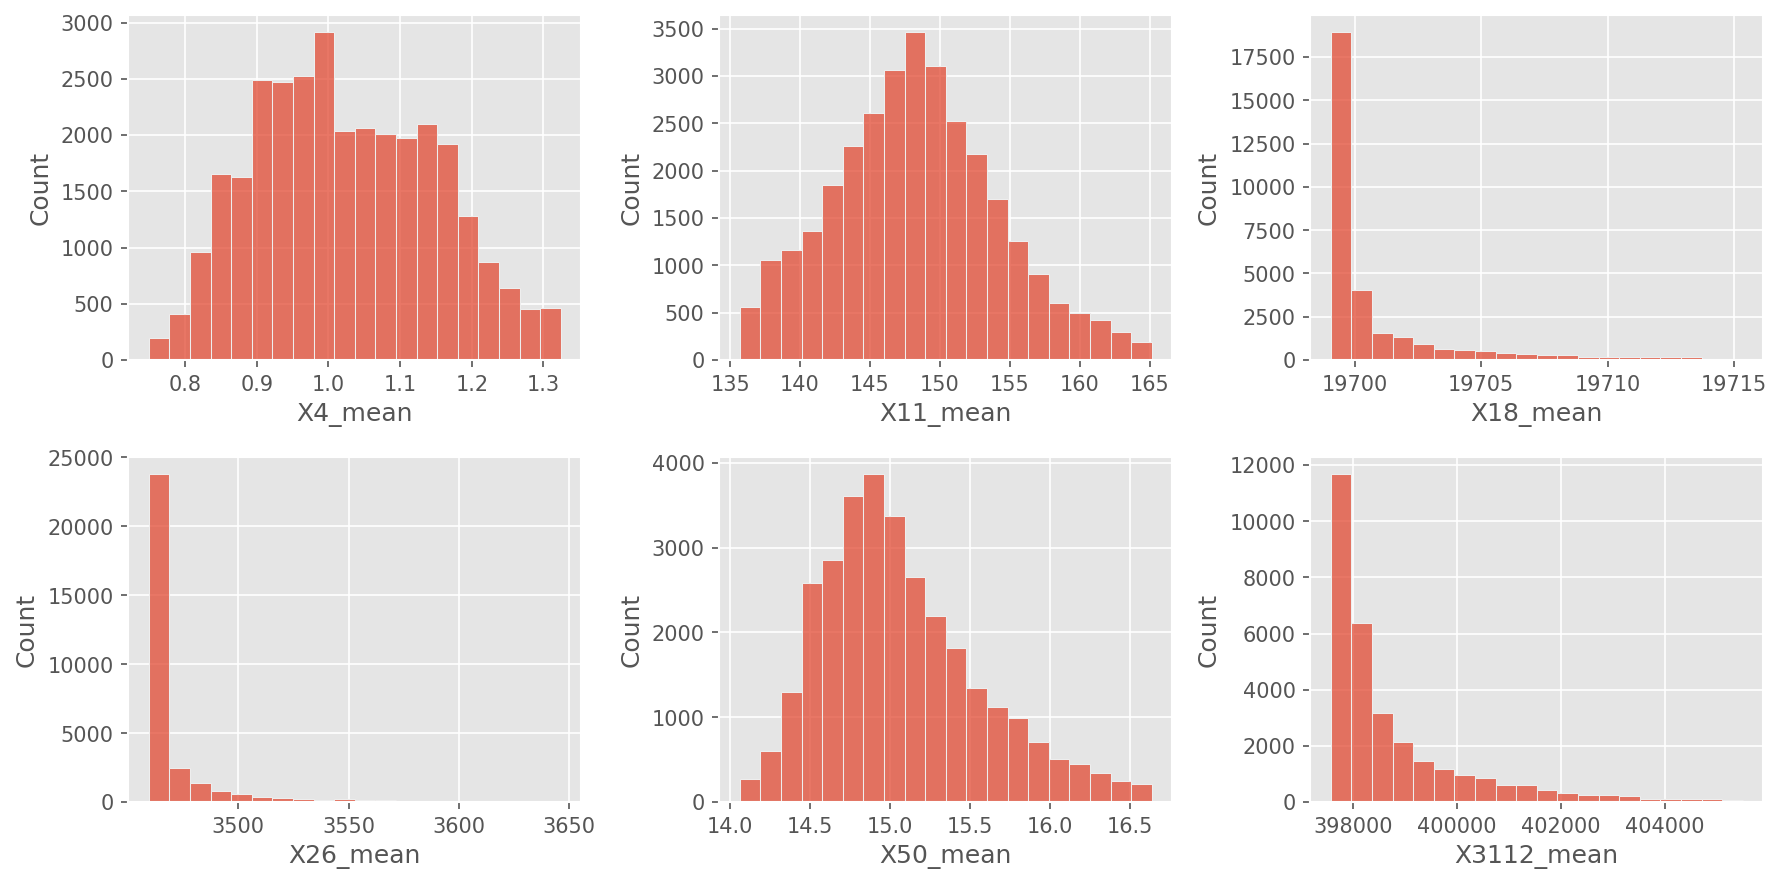

In [11]:
# histograms after filtering out bad observations
n_rows = 2
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i, column in enumerate(CONFIG.TRAITS_NAME):
    row_idx, col_idx = divmod(i, n_cols)
    _ = sns.histplot(data=train_df, x=column, ax=axs[row_idx, col_idx], bins=20)

fig.tight_layout()

# Defining the MODEL

# Define the Image Backbone and Tabular Model

In [12]:
class ImageBackbone_swin(nn.Module):
    def __init__(self, backbone_name, weight_path, out_features, fixed_feature_extractor=False):
        super().__init__()
        self.out_features = out_features
        self.backbone = timm.create_model('swin_large_patch4_window12_384.ms_in22k_ft_in1k', pretrained=True, num_classes=CONFIG.N_TARGETS)
        #self.backbone.load_state_dict(torch.load(weight_path))
        if fixed_feature_extractor:
            for param in self.backbone.parameters():
                param.requires_grad = False
        in_features = self.backbone.num_features
        
        self.backbone.head = nn.Identity()
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_features, out_features),
        )

    def forward(self, x):
        x = self.backbone(x)
        print(x.shape)
        x = x.permute(0, 3, 1, 2)
        return self.head(x)
    
    
class ImageBackbone_dinoV2(nn.Module):
    def __init__(self, backbone_name, weight_path, out_features, fixed_feature_extractor=False):
        super().__init__()
        self.out_features = out_features
        self.backbone = timm.create_model('vit_large_patch14_dinov2.lvd142m', pretrained=True, num_classes=0) #remove classifier nn.Linear
        #self.backbone = backbone_.forward_head(backbone_, pre_logits=True)
        if fixed_feature_extractor:
            for param in self.backbone.parameters():
                param.requires_grad = False
        in_features = self.backbone.num_features
        self.backbone.forward_head= nn.Identity()
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(out_features),
            nn.Flatten(),
            # nn.Linear(in_features, out_features),
        )

    def forward(self, x):
        x = self.backbone(x)
        #print(x.shape)
        x = x[:,  None,:]
        #print(x.shape)
        tt = self.head(x)
        #print(tt.shape)
        return tt

class TabularBackbone(nn.Module):
    def __init__(self, n_features, out_features):
        super().__init__()
        self.out_features = out_features
        self.fc = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            # nn.Dropout(0.1),
            nn.Linear(512, out_features),
        )

    def forward(self, x):
        return self.fc(x)    



# Combine the image feature extraction model with tabular feature extraction model 

In [13]:
def initialize_timm_model( model_name   , tim_num_class=0.0, fine_tuned_weight = None,fixed_feature_extractor=True):
    model_ft  = None
    if model_name == "resnet34" :
        """ Resnet34 """
        model = timm.create_model('resnet34' , num_classes=tim_num_class )
        return model
    if model_name == "Swin_Transformer":
        model = timm.create_model('swin_tiny_patch4_window7_224.ms_in22k' , pretrained=True , num_classes = tim_num_class)
        return model 
    if model_name == "swin_large":
        if fine_tuned_weight!=None:
            model = ImageBackbone_swin(model_name,fine_tuned_weight , tim_num_class,fixed_feature_extractor)
        else:
            model = timm.create_model('swin_large_patch4_window12_384.ms_in22k_ft_in1k',pretrained=True, num_classes = tim_num_class)
            #model.load_state_dict(torch.load(weight_path))
            model.head.drop = nn.Dropout(p=0.1,inplace=False)
        return model
    if model_name =="convnextv2":
        model = timm.create_model('convnext_tiny.in12k_ft_in1k_384',num_classes=tim_num_class)
        return model     
    if model_name == "efficientnet_v2":
        model = timm.create_model("efficientnet_b2.ra_in1k",pretrained = True)
        model.classifier = nn.Dropout(p=0.2,inplace=False)
        return model
    if model_name == "dinoV2":
        model = ImageBackbone_dinoV2(model_name,weight_path=None , out_features=tim_num_class,fixed_feature_extractor=fixed_feature_extractor)
        return model


# tm_model = initialize_timm_model("swin_large",tim_num_class=CONFIG.TIM_NUM_CLASS)
# data_config = timm.data.resolve_model_data_config(tm_model)
# transforms = timm.data.create_transform(**data_config, is_training=True)


In [14]:
class CustomModel(nn.Module):
    def __init__(self,input_channels,out_channels, target_features_num , tim_num_class , model_name):
        super().__init__()
        self.img_backbone = initialize_timm_model(model_name=model_name ,tim_num_class=tim_num_class , fine_tuned_weight = CONFIG.TIMM_FINED_TUNED_WEIGHT,fixed_feature_extractor=False)
        self.extra_features_model = TabularBackbone(n_features  = len(CONFIG.EXTRA_COLOUMN) , out_features=128)
        self.fc = nn.Sequential(
            nn.Linear(self.extra_features_model.out_features + self.img_backbone.out_features, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            # nn.Dropout(0.1),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, target_features_num),
        )        
    def forward(self,image,x):
        output_image = self.img_backbone(image) # bach * (hight*col)
        z = self.extra_features_model(x) # batch * 16
        inputs  = torch.cat((output_image,z), 1 )
        output = self.fc(inputs)
        return output
class BestModelSaveCallback:
    def __init__(self, save_path):
        self.save_path = save_path
        self.best_accuracy = -1

    def __call__(self, accuracy,model):
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            model.to(device = "cpu")
            torch.save(model.state_dict(), self.save_path)
            model.to(device=DEVICE)


In [15]:
if CONFIG.TIM_MODEL_NAME == "swin_large":
    if CONFIG.INCLUDE_EXTRA_FEATURES:
        model = CustomModel(input_channels = len(CONFIG.EXTRA_COLOUMN) ,out_channels =CONFIG.TABULAR_NN_OUTPUT, target_features_num= len(CONFIG.TRAITS_NAME), tim_num_class=CONFIG.TIM_NUM_CLASS , model_name=CONFIG.TIM_MODEL_NAME)
    else:
        model = initialize_timm_model(model_name=CONFIG.TIM_MODEL_NAME , tim_num_class = len(CONFIG.TRAITS_NAME) )    
    model.to(device = DEVICE)
elif CONFIG.TIM_MODEL_NAME == "dinoV2":
    if CONFIG.INCLUDE_EXTRA_FEATURES:
        model = CustomModel(input_channels = len(CONFIG.EXTRA_COLOUMN) ,out_channels =CONFIG.TABULAR_NN_OUTPUT, target_features_num= len(CONFIG.TRAITS_NAME), tim_num_class=CONFIG.TIM_NUM_CLASS , model_name=CONFIG.TIM_MODEL_NAME)
    else:
        model = initialize_timm_model(model_name=CONFIG.TIM_MODEL_NAME , tim_num_class = len(CONFIG.TRAITS_NAME) )    
    model.to(device = DEVICE)


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/swin_large_patch4_window12_384.ms_in22k_ft_in1k)
INFO:timm.models._hub:[timm/swin_large_patch4_window12_384.ms_in22k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [17]:
img = torch.ones(4,3,384,384).to(DEVICE)
features = torch.ones(4,len(CONFIG.EXTRA_COLOUMN)).to(DEVICE)
model(img,features).shape

torch.Size([4, 12, 12, 1536])


torch.Size([4, 6])

# Define Loss Metric for the Model and MISC

In [18]:
# optimizer
import torcheval.metrics
import torcheval.metrics.regression


optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=CONFIG.LR_MAX,
    weight_decay=CONFIG.WEIGHT_DECAY,
)

# lr scheduler
def get_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=CONFIG.LR_MAX,
        total_steps=CONFIG.N_STEPS,
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=1e1,
        final_div_factor=1e1,
    )
    
    
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val):
        self.sum += val.sum()
        self.count += val.numel()
        self.avg = self.sum / self.count
        
MSE = torcheval.metrics.regression.MeanSquaredError().to(DEVICE)
R2sc = torcheval.metrics.regression.R2Score(num_regressors=len(CONFIG.TRAITS_NAME) , multioutput="uniform_average").to(DEVICE)
R2sc_val = torcheval.metrics.regression.R2Score(num_regressors=len(CONFIG.TRAITS_NAME) , multioutput="uniform_average").to(DEVICE)
MSE_val = torcheval.metrics.regression.MeanSquaredError().to(DEVICE)
LOSS = AverageMeter()
LOSS_val = AverageMeter()
TARGET_TRAITS_MEAN = torch.tensor(train_df[CONFIG.TRAITS_NAME].mean().values).to(DEVICE)        # target mean accross the training dataset
EPS = torch.tensor([1e-6]).to('cuda')


# just to check if r2 loss is also decreasing 
def r2_loss(y_pred, y_true):
    ss_res = torch.sum((y_true - y_pred)**2, dim=0)
    ss_total = torch.sum((y_true - TARGET_TRAITS_MEAN)**2, dim=0)
    ss_total = torch.maximum(ss_total, EPS)
    r2 = torch.mean(ss_res / ss_total)
    return r2

LOSS_FN = nn.SmoothL1Loss() # r2_loss
LR_SCHEDULER = get_lr_scheduler(optimizer)

In [ ]:
# MSE = torcheval.metrics.regression.MeanSquaredError().to(DEVICE)
# y_pred = torch.ones(13,6).to(DEVICE)
# y = torch.randn(13,6).to(DEVICE)
# MSE.update(y_pred,y)
# MSE.compute().item()

In [ ]:
# y_pred = torch.ones(13,6).to(DEVICE)
# y = torch.randn(13,6).to(DEVICE)
# MSE.update(y_pred,y)
# MSE.compute().item()

In [20]:
def train_batch(inputs,model):
    model.train()  
    #X_image, X_tabular, y_true
    if CONFIG.INCLUDE_EXTRA_FEATURES :
        x,z,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        z = z.to(DEVICE)
        y_pred = model(x,z)        
        
    else:
        x,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)    
        y_pred = model(x)
    
    
    #loss_func = nn.MSELoss()
    #loss_val = loss_func(prediction,y)
    loss = LOSS_FN(y_pred,y) 
    LOSS.update(loss)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    LR_SCHEDULER.step()
    MSE.update(y_pred,y)
    R2sc.update(y_pred , y )
    return LOSS.avg.detach().cpu().numpy() ,MSE.compute().item() ,R2sc.compute().item()

@torch.no_grad
def do_prediction(inputs,model, is_val=False):
    global Train_std_tensor , Train_mean_tensor
    model.eval()
    if  CONFIG.INCLUDE_EXTRA_FEATURES:
        x,z,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        z = z.to(DEVICE)
        prediction = model(x,z)
    else:
        x,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        prediction = model(x)
    if is_val :
        prediction =prediction


@torch.no_grad()
def validation_loss_batch(inputs,model):
    global Train_std_tensor , Train_mean_tensor
    model.eval()
    if CONFIG.INCLUDE_EXTRA_FEATURES:
        x,z,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        z = z.to(DEVICE)
        prediction = model(x,z)
    else:
        x,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        prediction = model(x)
    prediction =prediction
    loss = LOSS_FN(prediction, y)
    LOSS_val.update(loss)
    MSE_val.update(prediction,y)
    R2sc_val.update(prediction , y )
    return LOSS_val.avg.detach().cpu().numpy() ,MSE_val.compute().item() ,R2sc_val.compute().item()

def utils_convert_to_2d_tensors(predictions,targets):
    predictions  = np.array(predictions)
    targets = np.array(targets)
    predictions  = np.reshape(predictions , (-1, predictions.shape[-1]))
    targets  = np.reshape(targets  , (-1 , targets.shape[-1]))
    return torch.Tensor(predictions), torch.Tensor(targets)

def train(trainLoader,valLoader,model,num_epochs,best_model_callback):
    #wandb.watch(model,loss_function,log = "all",log_freq=50)
    
    train_epoch_loss , train_epoch_r2 , train_epoch_mse =[] , [] , []
    val_epoch_loss , val_epoch_r2 , val_epoch_mse = [],[],[]
    
    
    for epoch in range(num_epochs):
        wandb.log({"epoch":epoch })
        # print(f"epoch: {epoch} , lr is { LR_SCHEDULER.get_last_lr()}" )
        train_loss_current_epoch ,train_mse_current_epoch, train_r2_current_epoch = [] , [] , []
        MSE.reset()
        R2sc.reset()
        LOSS.reset()
        # batch training loss
        with tqdm.tqdm(total=len(trainLoader)) as trainingLoop:
            for index,batch in enumerate(iter(trainLoader)): 
        
                loss,mse_ , r2_ = train_batch(batch,model)
                train_loss_current_epoch.append(loss)
                train_mse_current_epoch.append(mse_)
                train_r2_current_epoch.append(r2_)
                
                #trainingLoop.set_description(f"Epoch:{epoch} , Batch: {index}/{len(trainLoader)} ")
                #print(loss , mse_,  r2_ ,LR_SCHEDULER.get_last_lr())
                #trainingLoop.set_postfix({ "Training batch" : index , "loss is" : loss , "MSE" :  mse_ , "R2":  r2_, "lr was":  LR_SCHEDULER.get_last_lr()[0] })
                #trainingLoop.update(1)
                wandb.log({"Training-Loss":loss  , "Training-MSE" :  mse_ , "Training-R2":  r2_ })
        
        # train_epoch_loss.append(np.array(train_loss_current_epoch).mean() )
        # train_epoch_r2.append(np.array(train_r2_current_epoch).mean())
        # train_epoch_mse.append(np.array(train_mse_current_epoch).mean())

        MSE_val.reset()
        R2sc_val.reset()
        LOSS_val.reset()
                
        # validation set loss & accuracy  
        # val_loss_current_epoch ,val_mse_current_epoch, val_r2_current_epoch = [] , [] , []
        val_r2 = 0
        with tqdm.tqdm(total = len(valLoader)) as validationLoop:
            for index,batch in enumerate(iter(valLoader)):
                loss,mse_ , val_r2 = validation_loss_batch(batch,model)
                #val_loss_current_epoch.append(loss)
                #val_mse_current_epoch.append(mse_) 
                #val_r2_current_epoch.append(r2_)
                #validationLoop.set_description(f"Batch: {index}/{len(valLoader)}")
                #validationLoop.set_postfix({ "Validation batch" : index , "loss is" : loss , "MSE" :  mse_ , "R2":  val_r2 })
                ##wandb.log({"Vlaidation loss" : loss})
                wandb.log({"Validation-Loss":loss  , "Validation-MSE" :  mse_ , "Validation-R2":  val_r2 })
                #validationLoop.update(1)



        # val_epoch_loss.append(np.array(val_loss_current_epoch).mean())
        #val_epoch_r2.append(np.array(r2_).mean())
        # val_epoch_mse.append(np.array(mse_).mean())
        
        # print(f"epoch:{epoch}, Training (avg) loss : {train_epoch_loss[-1]} , Validation loss (avg) = {val_epoch_loss[-1]}")
        # print(f"epoch:{epoch}, Training (avg) r2 : {train_epoch_r2[-1]} , Validation r2(avg) = {val_epoch_r2[-1]}")
        
        best_model_callback(val_r2,model)        # save the best model according to the validation accuracy
        
        
    return train_epoch_loss,val_epoch_loss,train_epoch_r2 , val_epoch_r2


In [21]:

MODEL_NAME_SAVE = 'swin_pretrained_no_finetuned.pth'
best_model_callback = BestModelSaveCallback(save_path=os.path.join(CONFIG.BASE_DIR,MODEL_NAME_SAVE))
train_losses, val_losses , train_accuracies,val_accuracies = train(train_dataloader,validation_dataloader,model,CONFIG.NUM_EPOCHS,best_model_callback)

  0%|          | 0/242 [00:04<?, ?it/s]


KeyboardInterrupt: 